# User case: Belgica Bank time series

### Find Sentinel-1 data
Use the _SentinelAPI_ from _sentinelsat_ to find all Sentinel-1 imagery that covering a user-defined region of interest (ROI) in a given time period.
The ROI is defined as a polygon in a geojson file. Visit for "geojson.io" to create your own example.
The time period is hard-coded in the user-defined search parameters (starttime and endtime).


### Process the Sentinel-1 imagery
Use the Sentinel-1 name string to build the correct path to the location of the netcdf data on the met server. Load and calibrate HH and HV channel and visualize the data.


### Requirements
Requirement package are listed in "provision.sh".

In [1]:
# imports
import sys
from os import environ
from dotenv import load_dotenv
from loguru import logger

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from dateparser import parse

import xarray as xr
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# define loglevel
loglevel = 'INFO'
logger.remove()
logger.add(sys.stderr, level=loglevel)

1

### Enable copernicus scihub access

Use of the _sentinelAPI_ requires an account at _https://scihub.copernicus.eu/dhus/_. You can avoid hardcoding your scihub username and password in this notebook by using environment variables. To do this, create a file called ".env" with the following lines in the same folder as this notebook:

>DHUS_USER="your-scihub-username"  
>DHUS_PASSWORD="your-scihub-password"

__NB:__ Add the ".env" file to your ".gitignore" to avoid publishing it in your git repository!

In [3]:
# create environment variables stored in your ".env" file
load_dotenv()

# get copernicus.scihub username and password from environment variables
USERNAME = environ.get('DHUS_USER')
PASSWORD = environ.get('DHUS_PASSWORD')

# check that this was successful
if USERNAME == None:
    logger.error('USERNAME is: "None". Set variables correctly in ".env" file.')
if PASSWORD == None:
    logger.error('PASSWORD is: "None". Set variables correctly in ".env" file.')


### Define sentinelAPI search parameters

Define the search parameters for your query. The region of interest is defined as a polygon in geojson format. The _area_relation_ should be chosen depending on the size of your ROI and the specific needs of your project. For example, choose _Contains_ for a small ROI to ensure that the entire ROI is covered, or choose _Intersects_ for large ROIs to include all imagery that covers only parts of the ROI.

In [4]:
# define search parameters

# area and area relation
json_file = 'belgica_bank.geojson'
area_relation = 'Intersects'
##area_relation = 'Contains'

# time interval
starttime = parse('2022-04-01T00:00:00', settings={"DATE_ORDER": "YMD"})
endtime   = parse('2022-04-01T23:59:59', settings={"DATE_ORDER": "YMD"})

logger.debug(f'json_file:     {json_file}')
logger.debug(f'starttime:     {starttime}')
logger.debug(f'endtime:       {endtime}')
logger.debug(f'area_relatipn: {area_relation}')

In [5]:
# create Sentinel API
Sentinelapi = SentinelAPI(USERNAME, PASSWORD)

# query database
S1_result_dict = Sentinelapi.query(
    geojson_to_wkt(read_geojson(json_file)),
    date = (starttime,endtime),
    area_relation = area_relation,
    platformname = "Sentinel-1",
    producttype = "GRD"
)

### List search results

Get the number of results for your search parameters and write all the S1 name strings to a txt file. If you later want to download the SAFE folders of your search result, you can use this file to create download URLs for creodias (for example).

In [29]:
# get number of hits
n_imgs = len(S1_result_dict.keys())
logger.info(f'Found {n_imgs} Sentinel-1 images')

# initialize list of found images
img_list = []

# loop over search results, print, and append to img_list
for i,key in enumerate(S1_result_dict.keys()):
    logger.info(f"Image {i+1}/{n_imgs}: {S1_result_dict[key]['title']}")
    img_list.append(S1_result_dict[key]['title'])

# write search result S1 name strings to txt file
result_file = 'belgica_bank_S1_results.txt'
with open(result_file, 'w') as f:
    f.write('\n'.join(img_list))

2023-02-02 22:31:38.808 | INFO     | __main__:<module>:3 - Found 2 Sentinel-1 images
2023-02-02 22:31:38.810 | INFO     | __main__:<module>:10 - Image 1/2: S1A_EW_GRDM_1SDH_20220401T075454_20220401T075554_042577_051429_AACB
2023-02-02 22:31:38.812 | INFO     | __main__:<module>:10 - Image 2/2: S1A_EW_GRDM_1SDH_20220401T075349_20220401T075454_042577_051429_E721


### Test processing chain

Before looping over all search results, test the processing on the first hit.

In [13]:
# select first hit
S1_base = S1_result_dict[list(S1_result_dict.keys())[0]]['title']

### Build data URL

Use the S1 name string to build the correct path to the location of the netcdf data on the met server. 

In [14]:
# get date info from S1 name string
S1_year  = S1_base.split('_')[4][0:4]
S1_month = S1_base.split('_')[4][4:6]
S1_day   = S1_base.split('_')[4][6:8]

# get S1 mode and sensor
S1_sensor = S1_base[0:3]
S1_mode   = S1_base.split('_')[1]

# build url and open data set
S1_url = f'https://nbstds.met.no/thredds/dodsC/NBS/{S1_sensor}/{S1_year}/{S1_month}/{S1_day}/{S1_mode}/{S1_base}.nc'
logger.debug(f'S1_url: {S1_url}')
S1_dst = xr.open_dataset(S1_url)

### Load required data

Load HH and HV amplitude and calibration lookup table. The connection to the server with the netcdf data is slow, so for a first visualization, you may not want to load to entire image. 

In [18]:
# connection to the server is very slow
# sub-step when loading data set
stride = 5

# HH
DN_HH        = S1_dst["Amplitude_HH"][0,::stride,::stride]
LUT_HH       = S1_dst["sigmaNought_HH"][0,::stride,::stride]

# HV
DN_HV        = S1_dst["Amplitude_HV"][0,::stride,::stride]
LUT_HV       = S1_dst["sigmaNought_HV"][0,::stride,::stride]

# lat/lon
lon = S1_dst['lon'][::stride,::stride]
lat = S1_dst['lat'][::stride,::stride]

# get image footprint
lon_min_geo = np.min(lon)
lon_max_geo = np.max(lon)
lat_min_geo = np.min(lat)
lat_max_geo = np.max(lat)

# this is faster, but not all S1 netcdf products have these attributes
##lon_min_geo = S1_dst.attrs['geospatial_lon_min']
##lat_min_geo = S1_dst.attrs['geospatial_lat_min']
##lon_max_geo = S1_dst.attrs['geospatial_lon_max']
##lat_max_geo = S1_dst.attrs['geospatial_lat_max']

logger.debug(f'lon_min: {lon_min_geo}')
logger.debug(f'lon_max: {lon_max_geo}')
logger.debug(f'lat_min: {lat_min_geo}')
logger.debug(f'lat_max: {lat_max_geo}')

### Calibrate to sigma0 in dB

Use the LUT to calibrate HH and HV to sigma0 and convert to dB. The calibration is described here: _https://sentinels.copernicus.eu/web/sentinel/radiometric-calibration-of-level-1-products_

In [16]:
# calibrate HH and HV channel and convert to dB
sigma0_HH    = (DN_HH**2) / (LUT_HH**2)
sigma0_HV    = (DN_HV**2) / (LUT_HV**2)
sigma0_HH_dB = 10 * np.log10(sigma0_HH)
sigma0_HV_dB = 10 * np.log10(sigma0_HV)

### Find min/max values to adjust dynamic range

For better visualization, you may want to adjust the dynamic range of imshow or pcolormesh. You can either hardcode values, to make the color or grayscale of different images comparable, or you use flexible min and max values based on the percentiles of the data.

In [19]:
# find min/max percentiles for good visualization
vmin_HH = np.nanpercentile(sigma0_HH_dB, 0.5)
vmax_HH = np.nanpercentile(sigma0_HH_dB, 99.5)
vmin_HV = np.nanpercentile(sigma0_HV_dB, 0.5)
vmax_HV = np.nanpercentile(sigma0_HV_dB, 99.5)

logger.info(f'vmin_HH: {vmin_HH}')
logger.info(f'vmax_HH: {vmax_HH}')
logger.info(f'vmin_HV: {vmin_HV}')
logger.info(f'vmax_HV: {vmax_HV}')

2023-02-02 22:17:45.374 | INFO     | __main__:<module>:7 - vmin_HH: -24.03172492980957
2023-02-02 22:17:45.375 | INFO     | __main__:<module>:8 - vmax_HH: -0.9492515325546265
2023-02-02 22:17:45.376 | INFO     | __main__:<module>:9 - vmin_HV: -33.59486389160156
2023-02-02 22:17:45.377 | INFO     | __main__:<module>:10 - vmax_HV: -15.7661714553833


### Stack to false-color RGB

Use the min/max percentiles to normalize (scale) the individual channels and stack them to a false-color RGB image. A commonly used combination of channels for dual-pol data is for example red: HV, green: HH, blue: HH.

In [32]:
# create 8-bit false_color RGB
new_min = 0
new_max = 255

# linear map from sigma0 in dB to new_min and new_max
HH_scaled = (sigma0_HH_dB - (vmin_HH)) * ((new_max - new_min) / ((vmax_HH) - (vmin_HH))) + new_min
HV_scaled = (sigma0_HV_dB - (vmin_HV)) * ((new_max - new_min) / ((vmax_HV) - (vmin_HV))) + new_min

# clip values
HH_scaled = np.clip(HH_scaled, new_min, new_max)
HV_scaled = np.clip(HV_scaled, new_min, new_max)

# stack scaled channels to fals-color RGB
RGB = np.stack((HV_scaled,HH_scaled,HH_scaled),2)

### Visualize in radar geometry

Visualize the calibrated data (HH and HV as grayscale and false-color RGB) for a first visual check. Images are displayed in the radar geometry.

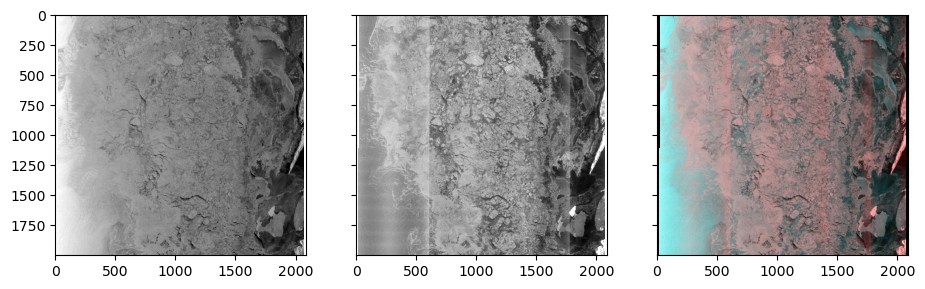

In [34]:
# visualize in radar geometry
fig, axes = plt.subplots(1,3,figsize=(11,4),sharex=True,sharey=True)
axes = axes.ravel()
axes[0].imshow(sigma0_HH_dB, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)
axes[1].imshow(sigma0_HV_dB, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)
axes[2].imshow(RGB/255)

# WORK FROM HERE

Search for overlapping optical.

Make RGB figures if possible. Extent? Projection?

Fix Belgica Bank ROI.

Loop over some images

### Visualize on map

Visualize the data on a map.

In [43]:
S1_dst

<xarray.Dataset>
Dimensions:                      (time: 1, y: 9991, x: 10435, gcp_index: 441)
Coordinates:
  * time                         (time) datetime64[ns] 2022-04-01T07:54:54
    lat                          (y, x) float32 ...
    lon                          (y, x) float32 ...
Dimensions without coordinates: y, x, gcp_index
Data variables: (12/40)
    Amplitude_HH                 (time, y, x) float32 ...
    Amplitude_HV                 (time, y, x) float32 ...
    crsWGS84                     int32 ...
    sigmaNought_HH               (time, y, x) float32 ...
    betaNought_HH                (time, y, x) float32 ...
    gamma_HH                     (time, y, x) float32 ...
    ...                           ...
    orbitList_HH                 int8 ...
    coordinateConversionList_HH  int8 ...
    swathMergeList_HH            int8 ...
    orbitList_HV                 int8 ...
    coordinateConversionList_HV  int8 ...
    swathMergeList_HV            int8 ...
Attributes: (12/26)
    title:                      Sentinel-1 GRD data
    netcdf4_version_id:         4.7.4
    file_creation_date:         2022-04-01T11:13:40Z
    ACQUISITION_START_TIME:     2022-04-01T07:54:54.065105
    ACQUISITION_STOP_TIME:      2022-04-01T07:55:54.059414
    BEAM_MODE:                  EW
    ...                         ...
    Conventions:                CF-1.6
    summary:                    Sentinel-1 C-band SAR GRD product.
    keywords:                   [Earth Science, Spectral/Engineering, RADAR, ...
    keywords_vocabulary:        GCMD Science Keywords
    institution:                Norwegian Meteorological Institute
    history:                    2022-04-01T11:13:40Z. Converted from SAFE to ...

TypeError: 'norm' must be an instance of matplotlib.colors.Normalize, str or None, not a numpy.ndarray

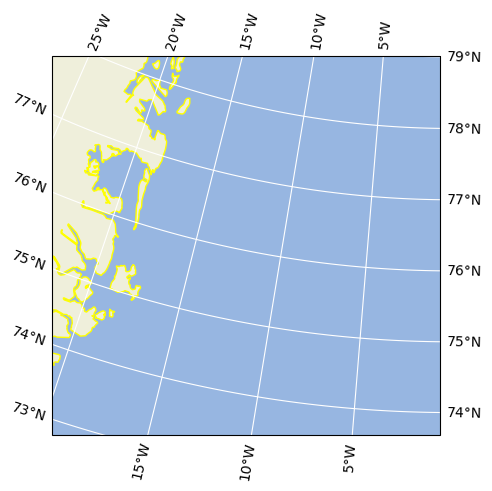

In [41]:
# define projections for the figure and the original set of coordinates
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

# create a figure handle
fig = plt.figure(figsize=(5,5))

# create an axes handle with the previously specified projection
ax = plt.axes(projection=target_projection)

# customise map and add features
ax.set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines(color='white',draw_labels=True, y_inline=False)
ax.coastlines(color='yellow')

##ax.imshow(ch_db, extent=extent, transform=projection, vmin=-30, vmax=0, cmap='gray', zorder=1)
ax.imshow(lon, lat, RGB, zorder=1)


##color_tuple = RGB.transpose((1,0,2)).reshape((RGB.shape[0]*RGB.shape[1],RGB.shape[2]))/255.
##plt.pcolormesh(lon, lat, RGB[:,:,0], color=color_tuple, transform=orig_projection, linewidth=0)
plt.pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)

In [39]:
print(lat[0,0])
print(lon[0,0])
print(lat[-1,-1])
print(lon[-1,-1])

<xarray.DataArray 'lat' ()>
array(76.94567, dtype=float32)
Coordinates:
    lat      float32 ...
    lon      float32 ...
Attributes:
    long_name:      latitude
    units:          degrees_north
    standard_name:  latitude
    _ChunkSizes:    [31 33]
<xarray.DataArray 'lon' ()>
array(-0.829521, dtype=float32)
Coordinates:
    lat      float32 ...
    lon      float32 ...
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    _ChunkSizes:    [31 33]
<xarray.DataArray 'lat' ()>
array(74.80637, dtype=float32)
Coordinates:
    lat      float32 ...
    lon      float32 ...
Attributes:
    long_name:      latitude
    units:          degrees_north
    standard_name:  latitude
    _ChunkSizes:    [31 33]
<xarray.DataArray 'lon' ()>
array(-20.462406, dtype=float32)
Coordinates:
    lat      float32 ...
    lon      float32 ...
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    _Ch

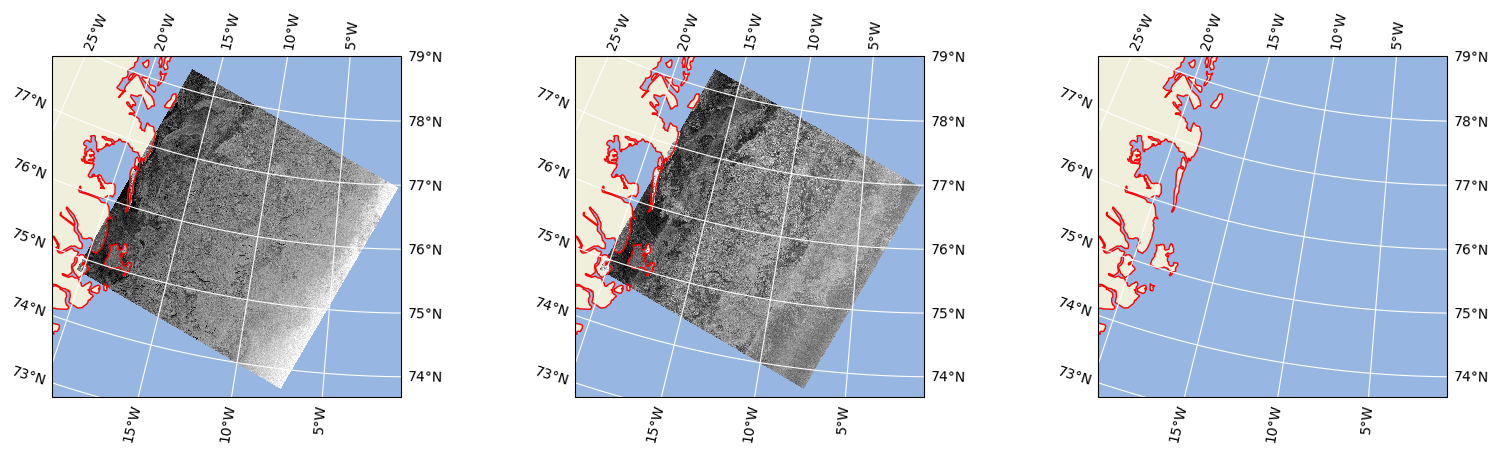

In [143]:
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw={'projection': target_projection})
axes = axes.ravel()

axes[0].set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])
axes[0].add_feature(cartopy.feature.LAND)
axes[0].add_feature(cartopy.feature.OCEAN)
axes[0].gridlines(color='white',draw_labels=True, y_inline=False)
axes[0].coastlines(color='red',resolution='10m')
axes[0].pcolormesh(lon, lat, sigma0_HH_dB, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)

axes[1].set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])
axes[1].add_feature(cartopy.feature.LAND)
axes[1].add_feature(cartopy.feature.OCEAN)
axes[1].gridlines(color='white',draw_labels=True, y_inline=False)
axes[1].coastlines(color='red',resolution='10m')
axes[1].pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)

axes[2].set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])
axes[2].add_feature(cartopy.feature.LAND)
axes[2].add_feature(cartopy.feature.OCEAN)
axes[2].gridlines(color='white',draw_labels=True, y_inline=False)
axes[2].coastlines(color='red',resolution='10m')
#axes[2].pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)

plt.subplots_adjust(left = None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

plt.savefig(f'{S1_base}_test_image.png', dpi=300)